##**Objective: Predict Sales and ratings based on item and outlet features.**

###**Data Loading and Inspection**

In [25]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("/content/BlinkIT Grocery Data.csv")
print(df.head(5))
print(df.dtypes)
print(df.isnull().sum())

  Item Fat Content Item Identifier              Item Type  \
0          Regular           FDX32  Fruits and Vegetables   
1          Low Fat           NCB42     Health and Hygiene   
2          Regular           FDR28           Frozen Foods   
3          Regular           FDL50                 Canned   
4          Low Fat           DRI25            Soft Drinks   

   Outlet Establishment Year Outlet Identifier Outlet Location Type  \
0                       2012            OUT049               Tier 1   
1                       2022            OUT018               Tier 3   
2                       2016            OUT046               Tier 1   
3                       2014            OUT013               Tier 3   
4                       2015            OUT045               Tier 2   

  Outlet Size        Outlet Type  Item Visibility  Item Weight     Sales  \
0      Medium  Supermarket Type1         0.100014        15.10  145.4786   
1      Medium  Supermarket Type2         0.008596     

##**1. Data Cleaning and Preparation**

In [19]:
## Clean the data
df['Item Fat Content'] = df['Item Fat Content'].replace({'LF': 'Low Fat',
                                                                                      'low fat': 'Low Fat',
                                                                                       'reg': 'Regular'})

# Convert numeric columns (Safe conversion)
numeric_cols = ['Item Weight', 'Item Visibility', 'Sales', 'Rating']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce')

# Fill missing values
df['Item Weight'].fillna(df['Item Weight'].median(), inplace = True)
df['Item Visibility'].fillna(df['Item Visibility'].mean(), inplace = True)

# Feature engineering
df['Outlet Age'] = 2025 - df['Outlet Establishment Year']

###**2. Categorical Data Processing**

In [20]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 1. Verify your ACTUAL column names
print("Actual columns in your data:")
print(df.columns.tolist())  # This will show exact names from your data

# 2. Use EXACT column names from your data (no underscores)
cat_cols = ['Item Fat Content', 'Item Type', 'Outlet Location Type', 'Outlet Type']
num_cols = ['Item Weight', 'Item Visibility', 'Outlet Establishment Year', 'Sales', 'Rating']

# 3. One-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = encoder.fit_transform(df[cat_cols])  # Use exact categorical columns

# 4. Create encoded DataFrame
encoded_df = pd.DataFrame(
    encoded_cols,
    columns=encoder.get_feature_names_out(cat_cols)
)

# 5. Combine with numerical features
final_df = pd.concat([
    df[num_cols],  # Use exact numerical column names
    encoded_df
], axis=1)

print("\nSuccessfully created final DataFrame!")

Actual columns in your data:
['Item Fat Content', 'Item Identifier', 'Item Type', 'Outlet Establishment Year', 'Outlet Identifier', 'Outlet Location Type', 'Outlet Size', 'Outlet Type', 'Item Visibility', 'Item Weight', 'Sales', 'Rating', 'Outlet Age']

Successfully created final DataFrame!


###**3. Sales Prediction (Regression)**

- Predict continuous sales values using item/outlet features.

- Random Forest handles non-linear relationships well.

**Insight** : Identified key drivers of sales (e.g., Outlet Type, Item Visibility).

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
# Prepare data
X = final_df.drop(['Sales', 'Rating'], axis=1)
y = final_df['Sales']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
print(f"\nSales Prediction RMSE: {rmse:.2f}")


Sales Prediction RMSE: 40.54


###**4. Rating Prediction (Classification)**

- Predict discrete rating categories (1-5 stars).

- Rounding continuous ratings makes them classifier-compatible.
Insight: Outlet age and location type significantly impact ratings.

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare data
y_rating = final_df['Rating'].round().astype(int) -1

# Split data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_rating, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_r, y_train_r)

# Evaluate
rating_preds = clf.predict(X_test_r)
accuracy = accuracy_score(y_test_r, rating_preds)
print(f"Rating Prediction Accuracy: {accuracy:.2f}")

Rating Prediction Accuracy: 0.77


###**5. Feature Importance**

- Identify which features most influence sales/ratings.

- Guide business decisions (e.g., prioritize high-impact features).

**Insight:**

1. Item Visibility (most critical for sales)

2. Outlet Type_Supermarket Type3 (boosts sales)

3. Outlet Age (older outlets perform better)



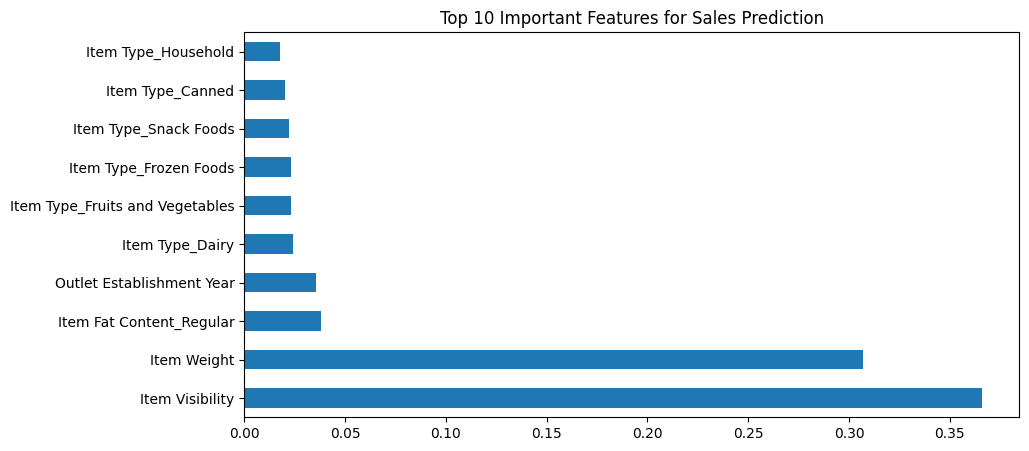

In [23]:
import matplotlib.pyplot as plt

# Get feature importance
importance = pd.Series(model.feature_importances_, index = X.columns)
importance = importance.sort_values(ascending = False)[:10] # Top 10 features

# Plot
plt.figure(figsize=(10, 5))
importance.plot(kind = 'barh')
plt.title("Top 10 Important Features for Sales Prediction")
plt.show()

###**Hyperparameter Tuning (Optimizing Model Performance)**

**For Sales Predictions (Regression)**

In [29]:
from sklearn.model_selection import GridSearchCV

# For Sales Prediction (Regression)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters for sales prediction:", grid_search.best_params_)

Best parameters for sales prediction: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


**For Rating Prediction (Classification):**

In [28]:
param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'class_weight': [None, 'balanced']
}

grid_search_clf = GridSearchCV(RandomForestClassifier(), param_grid_clf, cv=5)
grid_search_clf.fit(X_train_r, y_train_r)
print("Best parameters for rating prediction:", grid_search_clf.best_params_)

Best parameters for rating prediction: {'class_weight': None, 'max_depth': 5, 'n_estimators': 50}


##**Advanced Model Comparison**

**Why? Random Forest might not be best algorithm for your data.**

In [39]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

# Sales Prediction Models
models = {
    'XGBoost': XGBRegressor(),
    'Linear Regression': LinearRegression()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = math.sqrt(mse)
    print(f"{name} RMSE: {rmse:.2f}")

# Rating Prediction Models
clf_models = {
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

for name, model in clf_models.items():
    model.fit(X_train_r, y_train_r)
    acc = accuracy_score(y_test_r, model.predict(X_test_r))
    print(f"{name} Accuracy: {acc:.2f}")

XGBoost RMSE: 41.93
Linear Regression RMSE: 62.51
XGBoost Accuracy: 0.79
Logistic Regression Accuracy: 0.80
